In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

In [3]:
raw_data = '../data/raw'

In [4]:
train = pd.read_csv(f'{raw_data}/train.csv', low_memory=False)
train.head(1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1


In [5]:
y = train['Sales']

In [6]:
from sklearn.preprocessing import OneHotEncoder
train = pd.concat([train, train['StateHoliday']], axis=1)
train.drop(['StateHoliday'], axis=1, inplace=True)

In [7]:
train.drop(['Customers'], axis=1, inplace=True)

In [8]:
train['Date'] = pd.to_datetime(train['Date'])
for fld in ['year', 'week', 'day', 'dayofweek', 'dayofyear', 'weekday', 'weekofyear', 'quarter']:
    train[f'Date_{fld}'] = getattr(train['Date'].dt, fld)
train.head()
train.drop(['Sales'], axis=1, inplace=True)

In [9]:
import lightgbm as lgb

In [10]:
parameters = {
    'objective': 'binary',
    'learning_rate': 0.1,
    'num_threads': 4,
    "metric": 'auc'
}
n_rounds = 10000

lgb_train = lgb.Dataset(train, label=y, free_raw_data=False, )

In [11]:
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit
skf = TimeSeriesSplit(n_splits=3)

In [12]:
trn, val = next(skf.split(train))

In [13]:
train.iloc[trn]['Date'].min(), train.iloc[trn]['Date'].max()

(Timestamp('2014-12-12 00:00:00'), Timestamp('2015-07-31 00:00:00'))

In [14]:
# TODO: CV & timeseries splitting do not work out of the box
# https://github.com/microsoft/LightGBM/pull/298/files
# looks like no intersections to me, curious where's the leak though
train.iloc[val]['Date'].min(), train.iloc[val]['Date'].max()

(Timestamp('2014-04-02 00:00:00'), Timestamp('2014-12-12 00:00:00'))

In [15]:
train.drop(['Date'], axis=1, inplace=True)

In [16]:
result = lgb.cv(parameters, lgb_train, n_rounds, 
                folds=skf.split(train, y), early_stopping_rounds=10, verbose_eval=1, 
                   )

[1]	cv_agg's auc: 0.999825 + 6.81871e-05
[2]	cv_agg's auc: 0.999824 + 7.04435e-05
[3]	cv_agg's auc: 0.99983 + 6.3355e-05
[4]	cv_agg's auc: 0.999828 + 5.97586e-05
[5]	cv_agg's auc: 0.999827 + 5.86244e-05
[6]	cv_agg's auc: 0.999829 + 6.02801e-05
[7]	cv_agg's auc: 0.999828 + 5.85444e-05
[8]	cv_agg's auc: 0.999828 + 5.95454e-05
[9]	cv_agg's auc: 0.999829 + 5.85432e-05
[10]	cv_agg's auc: 0.999827 + 6.09077e-05
[11]	cv_agg's auc: 0.999826 + 5.87599e-05
[12]	cv_agg's auc: 0.999824 + 6.13358e-05
[13]	cv_agg's auc: 0.999825 + 5.91884e-05


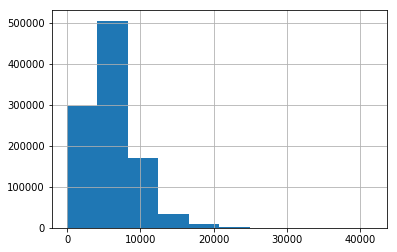

In [17]:
#there's fair bit of variability, I think I might just need drop y from train
y.hist()

In [18]:
model = lgb.LGBMRegressor(n_estimators = 1000, class_weight ='balanced')

In [21]:
def rmspe_number(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_lgb(yhat, y):
    return "rmspe", rmspe_number(y,yhat), False

# kaggle competition has RMSPE of around 0.1, so it's copypasting AUC is the source of confusion
trn, val = next(skf.split(train))
model.fit(train.iloc[trn], y.iloc[trn], verbose=1, eval_set = [(train.iloc[val], y.iloc[val])], 
          eval_metric = rmspe_lgb, early_stopping_rounds=10)

[1]	valid_0's l2: 3.49554e+07	valid_0's rmspe: 0.570365
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 3.46919e+07	valid_0's rmspe: 0.569158
[3]	valid_0's l2: 3.42843e+07	valid_0's rmspe: 0.567428
[4]	valid_0's l2: 3.43523e+07	valid_0's rmspe: 0.566604
[5]	valid_0's l2: 3.45716e+07	valid_0's rmspe: 0.566088
[6]	valid_0's l2: 3.40554e+07	valid_0's rmspe: 0.564199
[7]	valid_0's l2: 3.42767e+07	valid_0's rmspe: 0.563487
[8]	valid_0's l2: 3.48509e+07	valid_0's rmspe: 0.563765
[9]	valid_0's l2: 3.49374e+07	valid_0's rmspe: 0.563337
[10]	valid_0's l2: 3.50368e+07	valid_0's rmspe: 0.56298
[11]	valid_0's l2: 3.44817e+07	valid_0's rmspe: 0.5613
[12]	valid_0's l2: 3.50543e+07	valid_0's rmspe: 0.56215
[13]	valid_0's l2: 3.52016e+07	valid_0's rmspe: 0.561102
[14]	valid_0's l2: 3.53796e+07	valid_0's rmspe: 0.561179
[15]	valid_0's l2: 3.55907e+07	valid_0's rmspe: 0.561478
[16]	valid_0's l2: 3.52385e+07	valid_0's rmspe: 0.561101
Early stopping, best iteration is:
[6]	

LGBMRegressor(boosting_type='gbdt', class_weight='balanced',
              colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

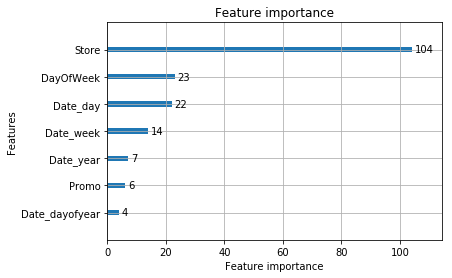

In [22]:
lgb.plot_importance(model)